In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
import statsmodels.formula.api as smf
import numpy as np
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate
import sys
from scipy.optimize import fmin

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Prices data for RIO, TLS and WES have been saved as my_data_pt2.csv, percentage log returns are calculated below
# Open, High, Low... for RIO only have been saved as RIO.AX.csv

stock_p = pd.read_csv('my_data_pt2.csv', index_col='Date', parse_dates=True, dayfirst=True)
d = pd.read_csv('RIO.AX.csv', index_col='Date', parse_dates=True, dayfirst=True)
data_rio = d['2010-01-05':]

In [4]:
stock_p

,RIO.AX,TLS.AX,WES.AX
Date,,,
2010-01-04,48.039593,1.825427,11.713983
2010-01-05,48.956516,1.820136,11.867620
2010-01-06,50.386421,1.788390,11.691500
2010-01-07,50.655743,1.756643,11.504133
2010-01-08,50.662155,1.788390,11.788928
...,...,...,...
2021-09-28,97.470001,3.930000,56.200001
2021-09-29,96.889999,3.900000,55.310001
2021-09-30,100.180000,3.930000,55.750000


In [7]:
rio = stock_p.iloc[:,0]
tls = stock_p.iloc[:,1]
wes = stock_p.iloc[:,2]

In [8]:
#checking for NaN values
stock_p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2973 entries, 2010-01-04 to 2021-10-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RIO.AX  2973 non-null   float64
 1   TLS.AX  2973 non-null   float64
 2   WES.AX  2973 non-null   float64
dtypes: float64(3)
memory usage: 92.9 KB


In [9]:
#Checking for entries = 0
(stock_p[:] == 0).sum()

RIO.AX    0
TLS.AX    0
WES.AX    0
dtype: int64

In [10]:
#checking for NaN values
data_rio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2972 entries, 2010-01-05 to 2021-10-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2972 non-null   float64
 1   High       2972 non-null   float64
 2   Low        2972 non-null   float64
 3   Close      2972 non-null   float64
 4   Adj Close  2972 non-null   float64
 5   Volume     2972 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 162.5 KB


In [11]:
#Checking for entries = 0
(data_rio[:] == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       1
dtype: int64

In [12]:
log_r = 100 * np.log(stock_p).diff().dropna()
log_r.info()
display(log_r)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2972 entries, 2010-01-05 to 2021-10-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RIO.AX  2972 non-null   float64
 1   TLS.AX  2972 non-null   float64
 2   WES.AX  2972 non-null   float64
dtypes: float64(3)
memory usage: 92.9 KB


,RIO.AX,TLS.AX,WES.AX
Date,,,
2010-01-05,1.890696,-0.290277,1.303050
2010-01-06,2.878924,-1.759547,-1.495167
2010-01-07,0.533089,-1.791110,-1.615568
2010-01-08,0.012658,1.791110,2.445441
2010-01-11,1.245229,-0.891572,0.285671
...,...,...,...
2021-09-28,-3.031454,-1.264238,-2.252028
2021-09-29,-0.596834,-0.766287,-1.596302
2021-09-30,3.339226,0.766287,0.792366


In [13]:
log_rio = log_r['RIO.AX']
log_wes = log_r['WES.AX']
log_tls = log_r['TLS.AX']

In [14]:
#Truncating the log return series, r is the in-sample data
r = log_rio[:'2019-10-15']
print(len(r))

# Volatility proxies

rng = 100 * (np.log(data_rio['High']) - np.log(data_rio['Low']))[1:]

proxy2 = 0.3607 * rng ** 2
proxy4 = np.exp(2 * np.log(rng) - 0.86 + 2 * 0.29 ** 2)

#Selecting the appropriate start date 

f_proxy2 = proxy2['2019-10-16':]
f_proxy4 = proxy4['2019-10-16':]

2472


## <u> Part 1 <u> question (a)

## 1.1 ARCH Model

In [15]:
#ARCH(p)-t Model Selection
aic = np.empty(15)
bic = np.empty(15)

for i in range(15):
    arch = arch_model(rio, mean='Constant', vol='ARCH', dist='StudentsT', p=(i + 1))
    fit = arch.fit(disp="off")
    aic[i] = fit.aic
    bic[i] = fit.bic

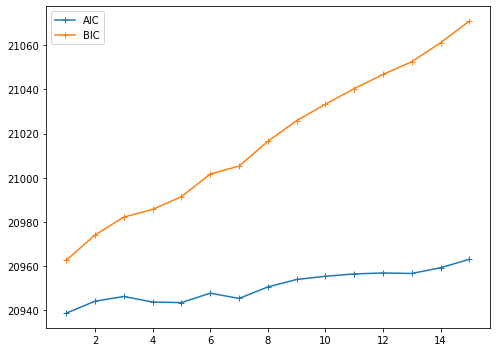

In [16]:
p = np.arange(1, 16)
plt.figure(figsize=(7, 5))
plt.plot(p, aic, '-+', label='AIC')
plt.plot(p, bic, '-+', label='BIC')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
tbl_ic = pd.DataFrame({'AIC': aic.round(0), 'BIC': bic.round(0)}, index=p)
tbl_ic.index.name = 'p'
tbl_ic.T

p,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
AIC,20939.0,20944.0,20946.0,20944.0,20943.0,20948.0,20945.0,20951.0,20954.0,20955.0,20956.0,20957.0,20957.0,20959.0,20963.0
BIC,20963.0,20974.0,20982.0,20986.0,20991.0,21002.0,21005.0,21016.0,21026.0,21033.0,21040.0,21047.0,21053.0,21061.0,21071.0


In [18]:
print(f'AIC:{np.argmin(aic) + 1}')
print(f'BIC:{np.argmin(bic) + 1}')

AIC:1
BIC:1


In [19]:
#ARCH(7)-t Model
#arch1t = arch_model(rio, mean='Constant', vol='ARCH', dist='StudentsT', p=7)
#arch1t_fit = arch1t.fit(disp="off")
#print(arch1t_fit.summary())

## 1.2 Reg-GARCH Model

In [20]:
#Reg-GARCH(p,q)-t - WES Model
aic = np.empty((5,5))
bic = np.empty((5,5))
for i in range(5):
    for j in range(5):
        arch = arch_model(rio, x = wes, mean='ARX', vol='GARCH', dist='StudentsT', p=(i + 1), q = (i+1))
        fit = arch.fit(disp="off")
        aic[i] = fit.aic
        bic[i] = fit.bic

In [21]:
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_aic_n = pd.DataFrame(aic.round(1), index=idx, columns=col)
tbl_aic_n

,q=1,q=2,q=3,q=4,q=5
p=1,19093.1,19093.1,19093.1,19093.1,19093.1
p=2,19094.0,19094.0,19094.0,19094.0,19094.0
p=3,19098.3,19098.3,19098.3,19098.3,19098.3
p=4,19092.3,19092.3,19092.3,19092.3,19092.3
p=5,19090.9,19090.9,19090.9,19090.9,19090.9


In [22]:
p_min = tbl_aic_n.min(axis=1).idxmin()
q_min = tbl_aic_n.idxmin(axis=1)[p_min]
aic_min = tbl_aic_n.min().min()
print('AIC:')
print(p_min)
print(q_min)
print(aic_min)

AIC:
p=5
q=1
19090.9


In [23]:
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_sic_n = pd.DataFrame(bic.round(1), index=idx, columns=col)
tbl_sic_n

,q=1,q=2,q=3,q=4,q=5
p=1,19129.0,19129.0,19129.0,19129.0,19129.0
p=2,19142.0,19142.0,19142.0,19142.0,19142.0
p=3,19158.3,19158.3,19158.3,19158.3,19158.3
p=4,19164.3,19164.3,19164.3,19164.3,19164.3
p=5,19174.8,19174.8,19174.8,19174.8,19174.8


In [24]:
p_min = tbl_sic_n.min(axis=1).idxmin()
q_min = tbl_sic_n.idxmin(axis=1)[p_min]
sic_min = tbl_sic_n.min().min()
print(p_min)
print(q_min)
print(sic_min)

p=1
q=1
19129.0


In [25]:
#Reg-GARCH(1,1)-t
#reg_garcht_rio = arch_model(rio, x = wes, mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='StudentsT')
#reg_garcht_rio_fit = reg_garcht_rio.fit( disp= 'off' )
#print(reg_garcht_rio_fit.summary())

## 1.3 Reg-GJR-GARCH Model

In [26]:
#Reg-GJR-GARCH(p,q)-t - TLS Model
aic = np.empty((5,5))
bic = np.empty((5,5))
for i in range(5):
    for j in range(5):
        arch = arch_model(rio, x = tls, mean='ARX', vol='GARCH', dist='StudentsT', p=(i + 1), q = (i+1))
        fit = arch.fit(disp="off")
        aic[i] = fit.aic
        bic[i] = fit.bic

In [27]:
#AIC - Reg-GJR-GARCH(p,q)-t
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_aic_n = pd.DataFrame(aic.round(1), index=idx, columns=col)
tbl_aic_n

,q=1,q=2,q=3,q=4,q=5
p=1,20640.4,20640.4,20640.4,20640.4,20640.4
p=2,20638.7,20638.7,20638.7,20638.7,20638.7
p=3,20639.8,20639.8,20639.8,20639.8,20639.8
p=4,20646.7,20646.7,20646.7,20646.7,20646.7
p=5,20648.1,20648.1,20648.1,20648.1,20648.1


In [28]:
p_min = tbl_aic_n.min(axis=1).idxmin()
q_min = tbl_aic_n.idxmin(axis=1)[p_min]
aic_min = tbl_aic_n.min().min()
print('AIC:')
print(p_min)
print(q_min)
print(aic_min)

AIC:
p=2
q=1
20638.7


In [29]:
#SIC - Reg-GJR-GARCH(p,q)-t
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_sic_n = pd.DataFrame(bic.round(1), index=idx, columns=col)
tbl_sic_n

,q=1,q=2,q=3,q=4,q=5
p=1,20676.3,20676.3,20676.3,20676.3,20676.3
p=2,20686.6,20686.6,20686.6,20686.6,20686.6
p=3,20699.7,20699.7,20699.7,20699.7,20699.7
p=4,20718.6,20718.6,20718.6,20718.6,20718.6
p=5,20732.1,20732.1,20732.1,20732.1,20732.1


In [30]:
p_min = tbl_sic_n.min(axis=1).idxmin()
q_min = tbl_sic_n.idxmin(axis=1)[p_min]
sic_min = tbl_sic_n.min().min()
print("SIC:")
print(p_min)
print(q_min)
print(sic_min)

SIC:
p=1
q=1
20676.3


Our three parametric models of choice include a ARCH(7)-t (Symmetric), Reg-GARCH(1,1)-t (Symmetric), and Reg-GJR-GARCH(1,1)-t (Asymmetric) models. All models are selected to follow a Student-t distribution due to the ability to allow for higher kurtosis, thus allowing for peaked distributions with fatter tails. Given that Student-t distributions were followed all errors were applied with a extra penalty of +1. 

In choosing a asymmetric model we were faced with the option of two primary asymmetric models, the GJR-GARCH(p,q)-t and EGARCH(p,q)-t. These models are considered asymmetric as negative impacts have a more significant impact on volatility compared to positive shocks. The choice of GJR-GARCH(p,q)-t was selected over the EGARCH(p,q)-t due to  

In motivating our choice of optimal p and q in the Reg-GJR-GARCH(p,q)-t model, we employ the use of both the AIC and the SIC. From this analysis, the asymmetric model of Reg-GJR-GARCH(p,q)-t has a suggested use of p=1 q=1 in both the AIC and SIC. The minimum p and q is preferred in the model selection as it is indicative of a better fitting model.  

Distribution? - why student t is better than normal

Furthermore, the ARCH(7)-t and Reg-GARCH(1,1) model's orders are selected on the same basis as the Reg-GJR-GARCH(1,1) model, through the AIC and SIC. The ARCH(7) graph depicts a minimum at p=7 in the SIC and p=13 in the AIC. Similar to the ARCH(7) model the Reg-GARCH(p,q)-t model also suggests a p=3 q=1 model in the AIC and a p=1 q=1 in the SIC. Thus based on choosing a parsimonious model p=7 is chosen in the ARCH model and p=1 q=1 is chosen in the instance of the Reg-GARCH model. 

## <u> Part 1 <u> question (b)

### i) Reg-GJR-GARCH(1,1) Estimation

In [31]:
#Reg-GJR-GARCH(1,1)-t
reg_gjgarcht_rio = arch_model(rio, x = tls, mean='ARX', lags=1, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
reg_gjgarcht_rio_fit = reg_gjgarcht_rio.fit( disp= 'off' )
print(reg_gjgarcht_rio_fit.summary())

                           AR-X - GJR-GARCH Model Results                           
Dep. Variable:                       RIO.AX   R-squared:                       0.998
Mean Model:                            AR-X   Adj. R-squared:                  0.998
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3864.72
Distribution:      Standardized Student's t   AIC:                           7745.44
Method:                  Maximum Likelihood   BIC:                           7793.41
                                              No. Observations:                 2972
Date:                      Tue, Nov 09 2021   Df Residuals:                     2969
Time:                              17:10:30   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [32]:
alpha0 = reg_gjgarcht_rio_fit.params['omega']
alpha1 = reg_gjgarcht_rio_fit.params['alpha[1]']
gamma = reg_gjgarcht_rio_fit.params['gamma[1]']
beta = reg_gjgarcht_rio_fit.params['beta[1]']

In [33]:
std = reg_gjgarcht_rio_fit.conditional_volatility.values[-1]
sg = std ** 2
a = -1;
sigtm1 = alpha0 + ((alpha1 + gamma) * a**2) + (beta * sg)
a = 1
sigta1 = alpha0 + (alpha1 * a**2) + (beta * sg)
print('\nPositive and negative shocks of size 1 and ratio: {}, {}, {}'.format(round(sigtm1,4), round(sigta1,4), round(sigtm1/sigta1,4)))
print(f'Positive Shock: {alpha1:.4f}')
print(f'Negative Shock: {alpha1+gamma:.4f}')
print(f'Volatility Persistance: {alpha1+beta:.4f}')
print(f'Volatility Persistance: {alpha1+beta+gamma/2:.4f}')


Positive and negative shocks of size 1 and ratio: 5.0168, 5.0035, 1.0026
Positive Shock: 0.0359
Negative Shock: 0.0492
Volatility Persistance: 0.9910
Volatility Persistance: 0.9976


The equation of our Reg-GJR-GARCH(1,1)-t estimation is as follows:

$r_t = 0.0178 + 0.0126RIO_{t-1} + 0.2929TLS_{t-1}$ 

$\sigma^2_t = 0.0455 + (0.0195 + 0.0505I_{t-1})a^2_{t-1} + 0.9390\sigma^2_{t-1}$ 

The mean model defines the relationship of current returns with previous period returns. The interpretation of the model is such that, there is a 0.0126 relationship between RIO_t and RIO_{t-1}, however due to the high p-value of 0.498 it is considered to be statistically indifferent from 0. Additionally, RIO_t has a 0.2929 correlation with TLS_{t-1} and is statistically significant given the p-value $\approx0$. 

Furthermore, the estimation provides a volatility model. The constant of $\omega$ is the volatility that is independent of previous shocks and the size of the shocks. In the event of no previous shocks and returns equalling the mean the volatility of RIO is expected to be 4.55%. The lag parameters of $\alpha_1$ and $\beta_1$ are significant at all conventional statistical levels with p-values $\approx$ 0. $\alpha_1$ captures the ARCH effect, when $\alpha_{t-1} > 0$ the variance is 0.0195 and 0.07 when $\alpha_{t-1} < 0$, thus the effect of yesterdays squared return shock more than triples when yesterdays return is negative. The $\beta_1$ captures the GARCH effect, the high $\beta_1$ of 0.9390 indicates that 93.9% of the pervious periods volatility is expected to persist over to the following period. The asymmetry of the model is captured in the parameter $\gamma$, which is statistically significant at the 5% level, with p-value $\approx$ 0.00. This finding supports the leverage effect indicating that the volatility of the model increases more in negatvie shocks than positive shocks of the same size. This is due to the rejection of $\gamma$ = 0 in favour of $\gamma$ > 0. Thus in the event of a 1% shock, the negative shock is expected increase the volatility by 1.01% more than the positive shock of the same size. Finally, the volatility persistence of model is very high at 0.9837 when $a_{t-1} < 0$ and 0.9585 when $a_{t-1} > 0$ indicating a slow mean reversion thus periods of high/low volatility are expected to persist for longer.  

### ii) Fit of Model

In [34]:
## Statistical diagnostics for G/ARCH models.
def assess_fit_stats( e, df ):
    ## Ljung-Box tests on standardised (transformed if t error) residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print( "Ljung-Box Q-statistic on standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## Ljung-Box tests on squared standardised (transformed if t error) residuals
    print( "Ljung-Box Q-statistic on squared standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e*e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## ARCH test on mean-corrected returns
    ## The null hypothesis is no ARCH errors.
    from statsmodels.stats.diagnostic import het_arch
    print( "Engle ARCH statistic:")
    for p in [ 5, 10 ]:
        Teststat, pValue, _, _ = het_arch( resid=e, nlags=p )
        print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
    print()

    ## Jarque-Bera tests (transformed errors if t error)
    from statsmodels.stats.stattools import jarque_bera
    print( 'Skewness: {0:f}'.format( stats.skew( e ) ) )
    print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e ) + 3 ) )
    JB_test_stat, JB_pvalue, _, _ = jarque_bera( e )
    print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
    print()

In [35]:
## Plot diagnostics for G/ARCH models.
def assess_fit_plots( e, name ):
    #Plot standardised residuals.
    plt.plot( e )
    plt.title( '{0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of standardised residuals.
    sm.graphics.tsa.plot_acf( e, lags=20 )
    plt.title( 'ACF of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the histogram of standardised residuals.
    plt.hist( e, bins = 25 )
    plt.title( 'Histogram of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## QQ plot of standardised residuals against the normal distribution.
    sm.qqplot( e, line = 'r')
    plt.title( 'QQ Plot of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of squared standardised residuals.
    sm.graphics.tsa.plot_acf( e*e, lags=20 )
    plt.title( 'ACF of {0} Squared Standardised Residuals'.format( name ) )
    plt.show()

In [36]:
dfgj = reg_gjgarcht_rio_fit.params['nu']
agj_t = reg_gjgarcht_rio_fit.resid
egj_t = reg_gjgarcht_rio_fit.std_resid
ugj = stats.t.cdf(np.sqrt(dfgj / (dfgj - 2)) * egj_t, dfgj)
egj = stats.norm.ppf(ugj)

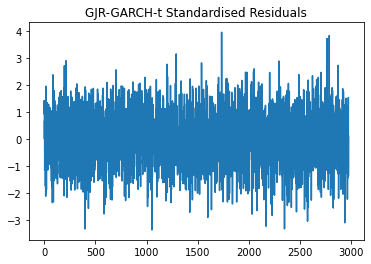

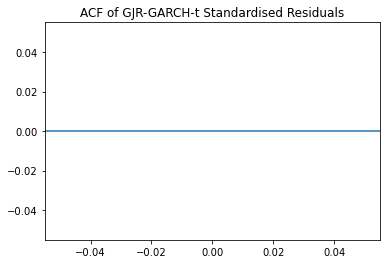

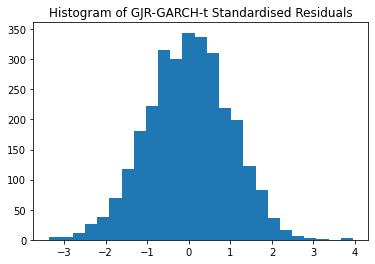

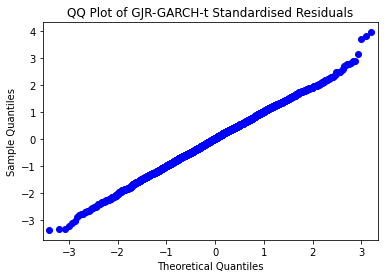

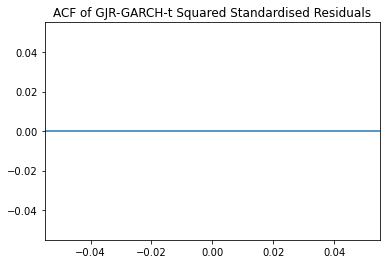

In [37]:
assess_fit_plots( egj, 'GJR-GARCH-t' )

In [ ]:
assess_fit_stats(egj, 4)

## iii) Model Misspecification

## <u> Part 1 <u> question (c)

In [39]:
frst_fc = '2019-10-16'
n_fore = len(log_rio[frst_fc:])
n_fore

500

In [40]:
# ARCH and Ad-hoc
farch7_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
fs2_100 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
fs2_25 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Re-instanciate the model objects with full data
arch7_t_all = arch_model(log_rio, mean='Constant', vol='ARCH', dist='StudentsT', p=7)

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 1 == 0:
        
        arch7_t_all_fit = arch7_t_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
         
    temp = arch7_t_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    farch7_t[i] = temp.loc[farch7_t.index[i]]
    
    # Ad-hoc methods
    fs2_100[i] = log_rio[(i + n_wind - 100):(i + n_wind)].var()
    fs2_25[i] = log_rio[(i + n_wind - 25):(i + n_wind)].var()
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
#Reg-GJR-GARCH-t
freg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Instantiate the Reg-GJR-GARCH-type model objects

y = log_rio
x = log_tls

n_fore = len(log_rio[frst_fc:])
n_wind = len(y) -  n_fore

for i in tqdm(range(n_fore)):
    # This one uses the 2019-10-15 of x to forecast 2019-10-16, and y is lagged
    y_is = y[i: (i + n_wind)]
    x_is = x[i: (i + n_wind)]
    reg_gjr_t = arch_model(y_is, mean='LS', x=x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
    
    if i % 1 == 0:
            reg_gjr_t_fit = reg_gjr_t.fit(disp = "off" )

    x_new = x[(i + n_wind): (i + n_wind + 1)]
    forecast = reg_gjr_t_fit.forecast(x=x_new, horizon=1, reindex=False).variance
    
    freg_gjr_t[i] = forecast.values[0]

  0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
#Reg-GARCH-t
freg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Instantiate the Reg-GARCH-type model objects

y = log_rio
x = log_wes

n_fore = len(log_rio[frst_fc:])
n_wind = len(y) -  n_fore

for i in tqdm(range(n_fore)):
    # This one uses the 2019-10-15 of x to forecast 2019-10-16, and y is lagged
    y_is = y[i: (i + n_wind)]
    x_is = x[i: (i + n_wind)]
    reg_garch_t = arch_model(y_is, mean='LS', x=x_is, vol='GARCH', p=1, q=1, dist='StudentsT')
    
    if i % 1 == 0:
            reg_garch_t_fit = reg_garch_t.fit(disp = "off" )

    x_new = x[(i + n_wind): (i + n_wind + 1)]
    forecast = reg_garch_t_fit.forecast(x=x_new, horizon=1, reindex=False).variance
    
    freg_garch_t[i] = forecast.values[0]

  0%|          | 0/500 [00:00<?, ?it/s]

### forecast

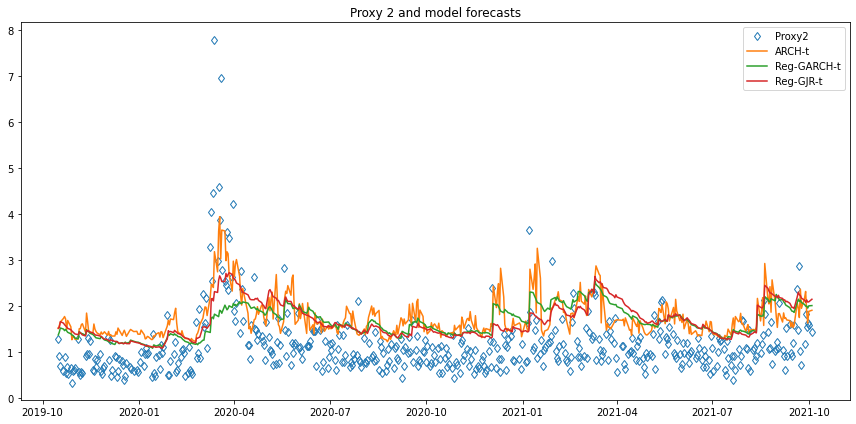

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy2')
plt.plot(np.sqrt(farch7_t), label='ARCH-t')
plt.plot(np.sqrt(freg_garch_t), label='Reg-GARCH-t')
plt.plot(np.sqrt(freg_gjr_t), label='Reg-GJR-t')

plt.title('Proxy 2 and model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

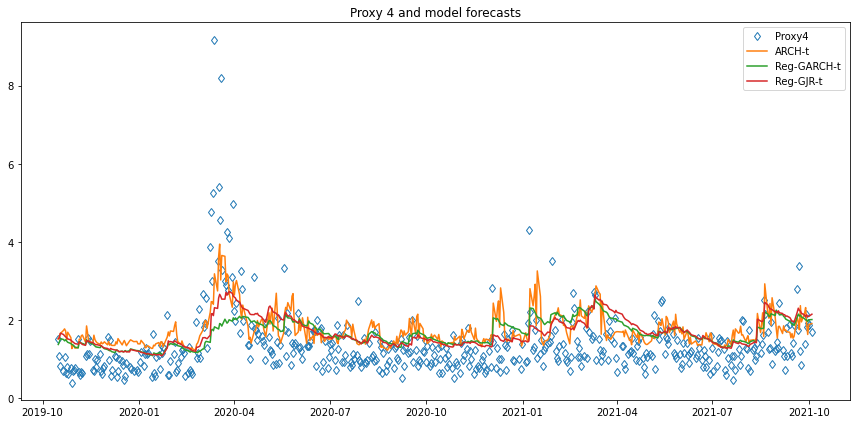

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy4), 'd', mfc='none', label='Proxy4')
plt.plot(np.sqrt(farch7_t), label='ARCH-t')
plt.plot(np.sqrt(freg_garch_t), label='Reg-GARCH-t')
plt.plot(np.sqrt(freg_gjr_t), label='Reg-GJR-t')

plt.title('Proxy 4 and model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

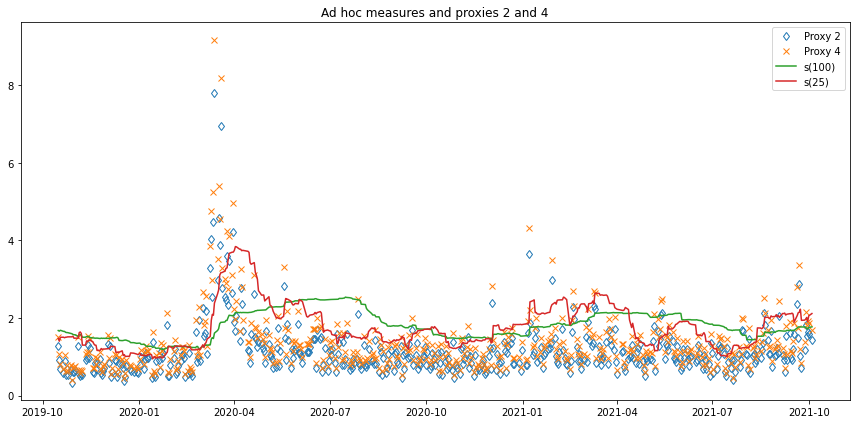

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy 2')
plt.plot(np.sqrt(f_proxy4), 'x', mfc='none', label='Proxy 4')

plt.plot(np.sqrt(fs2_100), label='s(100)')
plt.plot(np.sqrt(fs2_25), label='s(25)')
plt.title('Ad hoc measures and proxies 2 and 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### forecasting accuracy

In [48]:
f_model = np.vstack([farch7_t, freg_garch_t, freg_gjr_t, fs2_100, fs2_25]).T
f_proxy = np.vstack([f_proxy2, f_proxy4]).T

f_model = np.sqrt(f_model)
f_proxy = np.sqrt(f_proxy)

n_model = f_model.shape[1]
n_proxy = f_proxy.shape[1]

f_model_rep = f_model.repeat(n_proxy, axis=1)
f_proxy_rep = np.tile(f_proxy, [1, n_model])

rmse = np.sqrt(np.mean((f_model_rep - f_proxy_rep) ** 2, axis=0))
rmse = rmse.reshape(n_model, -1)

mad = np.mean(np.absolute(f_model_rep - f_proxy_rep), axis=0)
mad = mad.reshape(n_model, -1)

In [49]:
#RMSE
mdl_name = ['ARCH-t', 'Reg-GARCH-t', 'Reg-GJR-t', 's(100)', 's(25)']
prx_name = ['Proxy 2', 'Proxy 4']
tbl_rmse = pd.DataFrame(rmse, index=mdl_name, columns=prx_name)
tbl_rmse.round(4)

,Proxy 2,Proxy 4
ARCH-t,0.8351,0.8024
Reg-GARCH-t,0.8511,0.8568
Reg-GJR-t,0.8113,0.7999
s(100),1.0056,0.9862
s(25),0.9224,0.8784


In [50]:
#MAD
tbl_mad = pd.DataFrame(mad, index=mdl_name, columns=prx_name)
tbl_mad.round(4)

,Proxy 2,Proxy 4
ARCH-t,0.7015,0.6102
Reg-GARCH-t,0.6926,0.6050
Reg-GJR-t,0.6676,0.5805
s(100),0.8489,0.7534
s(25),0.7568,0.6557


### forecasting model combinations

In [51]:
# Last day of in-sample period
last_in = '2019-10-15'
# First day of forecasting period
frst_fc = '2019-10-16'
n_fore = len(log_rio[frst_fc:])
n_fore

# Leave out last 500 days for forecasting

500

In [52]:
# For VaR and ES calculations under Gaussian and Standardised-t distributions
def qn(p):
    return stats.norm.ppf(p)

def qt(p, df):
    return stats.t.ppf(p, df) * np.sqrt((df - 2) / df)

def esn(p):
    ninv = stats.norm.ppf(p)
    return -stats.norm.pdf(ninv) / p

def est(p, df):
    tinv = stats.t.ppf(p, df)
    f = lambda x: stats.t.pdf(x, df)
    return -f(tinv) / p * (df + tinv ** 2) / (df - 1) * np.sqrt((df - 2) / df)

def mcn(p, n):
    z = np.random.normal(size=n)
    var = np.quantile(z, p)
    es = np.mean(z[z < var])
    return (var, es)

def mct(p, df, n):
    t = np.random.standard_t(df, size=n)
    z = t * np.sqrt((df - 2) / df)
    var = np.quantile(z, p)
    es = np.mean(z[z < var])
    return (var, es)

def es(r, p):
    var = np.quantile(r, p)
    return np.mean(r[r < var])

def es_to_var_n(p):
    ninv = stats.norm.ppf(p)
    return stats.norm.cdf((-1 / p) * stats.norm.pdf(ninv))

def es_to_var_t(p, df):
    tinv = stats.t.ppf(p, df)
    tpdf = stats.t.pdf(tinv, df)
    temp = (-1 / p) * tpdf * (df + tinv ** 2) / (df - 1)
    return stats.t.cdf(temp, df)

In [53]:
# Reg_GJR-GARCH-t, HS100 and HS200

var25_arch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var1_arch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es25_arch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es1_arch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var25_reg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var1_reg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es25_reg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es1_reg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

var25_hs100 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var1_hs100 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es25_hs100 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es1_hs100 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var25_hs200 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var1_hs200 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es25_hs200 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es1_hs200 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Volatility
s_arch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
s_reg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
s_hs100 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
s_hs200 = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_arch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
df_reg_gjr_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = log_rio[1:]
x = log_tls[:-1]
arch_t = arch_model(y, mean='Constant', vol='ARCH', dist='StudentsT', p=7)


n_fore = len(log_rio[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    arch_t = arch_model(y_is, mean='Constant', vol='ARCH', dist='StudentsT', p=7)
    reg_gjr_t = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 1 == 0:
            arch_t_fit = arch_t.fit( disp = "off" )
            reg_gjr_t_fit = reg_gjr_t.fit( disp = "off" )
       
    # ARX-GJR-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_gjr_t_fit.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit.params['nu'])
    var25_reg_gjr_t[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit.params['nu'])
    es25_reg_gjr_t[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_gjr_t[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_gjr_t[i] = reg_gjr_t_fit.params['nu']
    if var25_reg_gjr_t[i] > 0:
        var25_reg_gjr_t[i] = var25_reg_gjr_t[i-1]
        es25_reg_gjr_t[i] = es25_reg_gjr_t[i-1]
        var1_reg_gjr_t[i] = var1_reg_gjr_t[i-1]
        es1_reg_gjr_t[i] = es1_reg_gjr_t[i-1]
        s_reg_gjr_t[i] = s_reg_gjr_t[i-1]
    
    
    # ARCH-t
    fc = arch_t_fit.forecast(horizon=1, reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, arch_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, arch_t_fit.params['nu'])
    var25_arch_t[i] = temp25.values #.loc[var25_gjr_t2.index[i]]
    var1_arch_t[i] = temp1.values #.loc[var1_gjr_t2.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, arch_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, arch_t_fit.params['nu'])
    es25_arch_t[i] = es25.values #.loc[es25_gjr_t2.index[i]]
    es1_arch_t[i] = es1.values #.loc[es1_gjr_t2.index[i]]
    s_arch_t[i] = s.values #.loc[s_gjr_t2.index[i]]
    df_arch_t[i] = arch_t_fit.params['nu'] 
    
    # HS-100
    var25_hs100[i] = log_rio[(i + n_wind - 100):(i + n_wind)].quantile(0.025)
    var1_hs100[i] = log_rio[(i + n_wind - 100):(i + n_wind)].quantile(0.01)
    es25_hs100[i] = es(log_rio[(i + n_wind - 100):(i + n_wind)], 0.025)
    es1_hs100[i] = es(log_rio[(i + n_wind - 100):(i + n_wind)], 0.01)
    s_hs100[i] = log_rio[(i + n_wind - 100):(i + n_wind)].std()
    
    # HS-200
    var25_hs200[i] = log_rio[(i + n_wind - 200):(i + n_wind)].quantile(0.025)
    var1_hs200[i] = log_rio[(i + n_wind - 200):(i + n_wind)].quantile(0.01)
    es25_hs200[i] = es(log_rio[(i + n_wind - 200):(i + n_wind)], 0.025)
    es1_hs200[i] = es(log_rio[(i + n_wind - 200):(i + n_wind)], 0.01)
    s_hs200[i] = log_rio[(i + n_wind - 200):(i + n_wind)].std()

  0%|          | 0/500 [00:00<?, ?it/s]

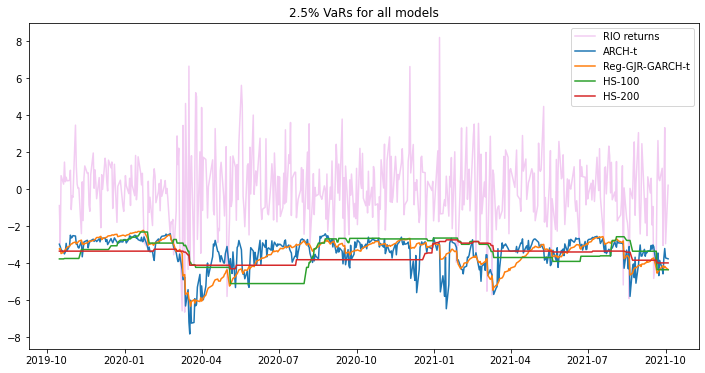

In [54]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var25_arch_t, label='ARCH-t')
plt.plot(var25_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(var25_hs100, label='HS-100')
plt.plot(var25_hs200, label='HS-200')

plt.title('2.5% VaRs for all models')
plt.legend()
plt.show()

In [55]:
#Reg-GARCH-t

var25_reg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var1_reg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es25_reg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
es1_reg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Volatility
s_reg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_reg_garch_t = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = log_rio[1:]
x = log_wes[:-1]

n_fore = len(log_rio[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    reg_garch_t = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, dist='StudentsT')

    if i % 1 == 0:
            reg_garch_t_fit = reg_garch_t.fit( disp = "off" )
       
    # ARX-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_garch_t_fit.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit.params['nu'])
    var25_reg_garch_t[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_garch_t[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_garch_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_garch_t_fit.params['nu'])
    es25_reg_garch_t[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_garch_t[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_garch_t[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_garch_t[i] = reg_garch_t_fit.params['nu']
    if var25_reg_gjr_t[i] > 0:
        var25_reg_garch_t[i] = var25_reg_garch_t[i-1]
        es25_reg_garch_t[i] = es25_reg_garch_t[i-1]
        var1_reg_garch_t[i] = var1_reg_garch_t[i-1]
        es1_reg_garch_t[i] = es1_reg_garch_t[i-1]
        s_reg_garch_t[i] = s_reg_garch_t[i-1]

  0%|          | 0/500 [00:00<?, ?it/s]

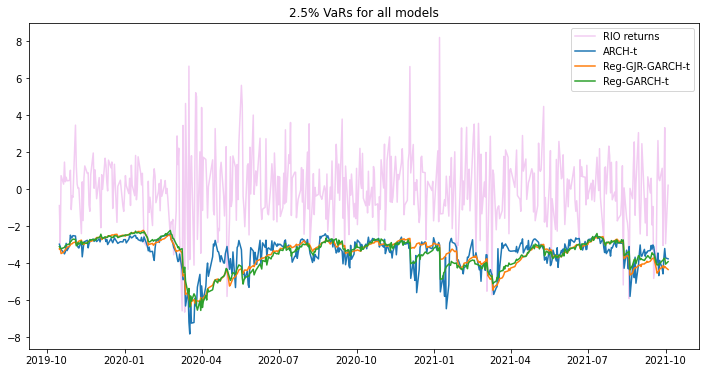

In [56]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var25_arch_t, label='ARCH-t')
plt.plot(var25_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(var25_reg_garch_t, label='Reg-GARCH-t')

plt.title('2.5% VaRs for all models')
plt.legend()
plt.show()

In [57]:
'''
CaViaR loss function
More efficient than qregCaViaR
b: vector of model parameters.
r: vector of returns.
p: scalar, indicating probability level.
q0: scalar, initial quantile.
returns: scalar, loss function value.
'''
def caviar_loss(b, r, p, q0):
    n = len(r)
    q = np.empty(n)
    q[0] = q0
    for t in range(1, n):
        q[t] = b[0] + b[1] * q[t - 1] + b[2] * np.abs(r[t - 1])
    
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    return p * np.sum(x1 - f1) + (1 - p) * np.sum(f2 - x2)

def caviar_est(b, r, p, q0):
    n = len(r)
    q = np.empty(n)
    q[0] = q0
    for t in range(1, n):
        q[t] = b[0] + b[1] * q[t - 1] + b[2] * np.abs(r[t - 1])
        
    return q   

'''
CaViaR update function
b: vector of model parameters.
r: vector of returns.
p: scalar, indicating probability level.
q0: scalar, initial quantile.
returns: vector of one-step-ahead forecasts, aligned with r.
'''
def caviar_update(b, r, p, q0):
    q = pd.Series(index=r.index, dtype='float64')
    q[0] = q0
    for t in range(1, len(r)):
        q[t] = b[0] + b[1] * q[t - 1] + b[2] * np.abs(r[t - 1])
    return q

In [58]:
b02 = [-0.1, 0.8, -0.3]

In [59]:
n_fore = len(log_rio[frst_fc:])
n_wind = len(log_rio[:last_in])
#n_fore=10
#n_wind=100

var25_caviar = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')
var1_caviar = pd.Series(index=log_rio[frst_fc:].index, dtype='float64')

for i in tqdm(range(n_fore)):
    if i % 1 == 0:
        q025 = np.quantile(log_rio[i:(i + n_wind)], 0.025)
        q01 = np.quantile(log_rio[i:(i + n_wind)], 0.01)
        
        caviar25_par = fmin(caviar_loss, x0=b02, args=(log_rio[i:(i + n_wind)], 0.025, q025), disp=False)
        caviar1_par = fmin(caviar_loss, x0=b02, args=(log_rio[i:(i + n_wind)], 0.01, q01), disp=False)
        
        temp25 = caviar_update(caviar25_par, log_rio, 0.025, q025)
        temp1 = caviar_update(caviar1_par, log_rio, 0.01, q01)
        
    var25_caviar[i] = temp25.loc[var25_caviar.index[i]]
    var1_caviar[i] = temp1.loc[var1_caviar.index[i]]

  0%|          | 0/500 [00:00<?, ?it/s]

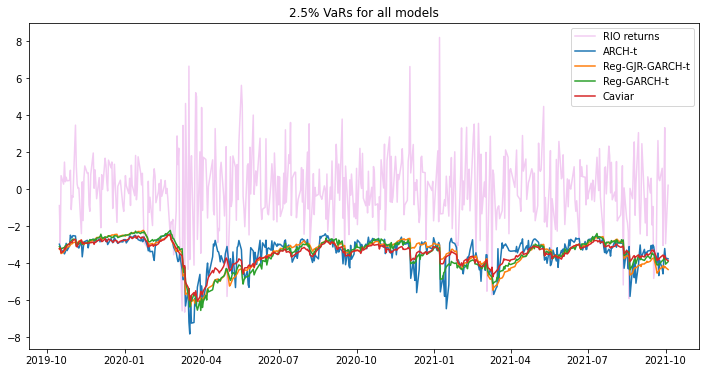

In [60]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var25_arch_t, label='ARCH-t')
plt.plot(var25_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(var25_reg_garch_t, label='Reg-GARCH-t')
plt.plot(var25_caviar, label='Caviar')

plt.title('2.5% VaRs for all models')
plt.legend()
plt.show()

In [61]:
# ES residuals
def es_resid(es, var, s, r):
    xi = r[r < var] - es[r < var]
    return (xi.dropna(), (xi / s).dropna())

def ttest(x, mu):
    n = len(x)
    xbar = np.mean(x)
    s = np.std(x, ddof=1)
    t = (xbar - mu) / (s / np.sqrt(n))
    pval = 2 * stats.t.sf(np.abs(t), df=(n - 1))
    return pval, t

# Unconditional coverage test
def uctest(hit, a):
    n = len(hit)
    p = np.sum(hit) / n
    z = (p - a) / np.sqrt(a * (1 - a) / n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p

# Independence test
def indtest(hits):
    n = len(hits)

    r5 = hits.values[1:]
    r51 = hits.values[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)
  
    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

# Dynamic quantile test
def dqtest(y,f,a,lag):
    n = len(y)
    hits = ((y<f)*1)*(1-a)
    hits = (hits)*1+(y>f)*(-a)
    q=2+lag
    
    if np.sum((y<f)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), f[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])
    
        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq

# Quantile loss function
def qloss(q,r,p):
    q = np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Joint loss function
def jointloss(es,q,r,p):
    m = len(r)
    q = np.array(q)
    es = np.array(es)
    i1 = (r < q).astype(int)
    aes = es ** (-1) * (p-1)
    ees = (r-q) * (p - i1)
    l =  np.sum(-np.log(aes)) - np.sum(ees / es) / p
    l = l / m
    return l

# Accuracy checks for VaR
def check_var_fc(var_fc, r, p):
    hit = r < var_fc
    n_hit = np.sum(hit)
    pval_uc, p_hat = uctest(hit, p)
    pval_ind = indtest(hit)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    qtl_loss = qloss(var_fc, r, p)
    return [n_hit, p_hat, p_hat / p, pval_uc, pval_ind, pval_dq, qtl_loss]

# Accuracy checks for ES
def check_es_fc(es, var, s, r):
    hit = r < var
    n_hit = np.sum(hit)
    xi, xis = es_resid(es, var, s, r)
    t_xi = ttest(xi, 0)[1]
    t_xis = ttest(xis, 0)[1]
    p_xis = ttest(xis, 0)[0]
    return [n_hit, np.mean(xi), t_xi, np.mean(xis), t_xis, p_xis]

def check_es_fc_ex_10(es, var, s, r, p):
    hit = r < es
    n_hit = np.sum(hit)
    xi, xis = es_resid(es, var, s, r)
    rmse = np.sqrt(np.mean(xi ** 2))
    mad = np.mean(np.abs(xi))
    t_xi = ttest(xi, 0)[1]
    t_xis = ttest(xis, 0)[1]
    p_xis = ttest(xis, 0)[0]
    jl = jointloss(es, var, r, p)
    return [n_hit, np.mean(xi), t_xi, np.mean(xis), t_xis, p_xis, jl, rmse, mad]

### Forecast combination formation

In [62]:
# RMSE weights
rmse_sum = 0.8351+0.8511+0.8113+1.0056+0.9224
w1 = (1/(0.8351/rmse_sum))
w2 = (1/(0.8511/rmse_sum))
w3 = (1/(0.8113/rmse_sum))
w4 = (1/(1.0056/rmse_sum))
w5 = (1/(0.9224/rmse_sum))
w_sum = w1+w2+w3+w4+w5

# Find Quantile Loss for VaR for 1 and 2.5%
# Find Joint Loss for ES at 1 and 2.5%

In [63]:
# Volatility
#1 
vol_fcomb1 = (farch7_t + freg_garch_t + freg_gjr_t)/3

#2
vol_fcomb2 = (farch7_t + freg_garch_t + freg_gjr_t + fs2_100 + fs2_25)/5

#3 forecast * (1/(RMSE/Sum of RMSE))
vol_fcomb3 = (farch7_t*w1 + freg_garch_t*w2 + freg_gjr_t*w3 + fs2_100*w4 + fs2_25*w5)/w_sum

In [64]:
#QLoss weights 2.5%
loss_sum = 61.8129+62.0395+62.9995+62.3852+72.0568+67.8182
w1 = (1/(61.8129/loss_sum))
w2 = (1/(62.0395/loss_sum))
w3 = (1/(62.9995/loss_sum))
w4 = (1/(62.3852/loss_sum))
w5 = (1/(72.0568/loss_sum))
w6 = (1/(67.8182/loss_sum))
w_sum = w1+w2+w3+w4+w5+w6

In [65]:
# VaR 2.5%
#1
var25_fcomb1 = (var25_arch_t + var25_reg_gjr_t + var25_reg_garch_t + var25_caviar)/4

#2
var25_fcomb2 = (var25_arch_t + var25_reg_gjr_t + var25_reg_garch_t + var25_caviar + var25_hs100 + var25_hs200)/6

#3

var25_fcomb3 = (var25_arch_t*w1 + var25_reg_gjr_t*w2 + var25_reg_garch_t*w3 + var25_caviar*w4 + var25_hs100*w5 + var25_hs200*w6)/w_sum

In [66]:
#QLoss weights 1%
loss_sum = 35.99+35.834+36.653+36.214+45.858+40.878
w1 = (1/(35.99/loss_sum))
w2 = (1/(35.834/loss_sum))
w3 = (1/(36.653/loss_sum))
w4 = (1/(36.214/loss_sum))
w5 = (1/(45.858/loss_sum))
w6 = (1/(40.878/loss_sum))
w_sum = w1+w2+w3+w4+w5+w6

In [67]:
# VaR 1%
#1
var1_fcomb1 = (var1_arch_t + var1_reg_gjr_t + var1_reg_garch_t + var1_caviar)/4

#2
var1_fcomb2 = (var1_arch_t + var1_reg_gjr_t + var1_reg_garch_t + var1_caviar + var1_hs100 + var1_hs200)/6

#3
var1_fcomb3 = (var1_arch_t*w1 + var1_reg_gjr_t*w2 + var1_reg_garch_t*w3 + var1_caviar*w4 + var1_hs100*w5 + var1_hs200*w6)/w_sum

In [68]:
#JLoss weights 2.5%
loss_sum = 2.61+2.61+2.64+2.88+2.77
w1 = (1/(2.61/loss_sum))
w2 = (1/(2.61/loss_sum))
w3 = (1/(2.64/loss_sum))
w4 = (1/(2.88/loss_sum))
w5 = (1/(2.77/loss_sum))
w_sum = w1+w2+w3+w4+w5

In [69]:
# ES 2.5%
#1
es25_fcomb1 = (es25_arch_t + es25_reg_gjr_t + es25_reg_garch_t)/3

#2
es25_fcomb2 = (es25_arch_t + es25_reg_gjr_t + es25_reg_garch_t + es25_hs100 + es25_hs200)/5


#3
es25_fcomb3 = (es25_arch_t*w1 + es25_reg_gjr_t*w2 + es25_reg_garch_t*w3 + es25_hs100*w4 + es25_hs200*w5)/w_sum


In [70]:
#JLoss weights 1%
loss_sum = 2.82+2.76+2.83+3.30+3.15
w1 = (1/(2.82/loss_sum))
w2 = (1/(2.76/loss_sum))
w3 = (1/(2.83/loss_sum))
w4 = (1/(3.30/loss_sum))
w5 = (1/(3.15/loss_sum))
w_sum = w1+w2+w3+w4+w5

In [71]:
# ES 1%
#1
es1_fcomb1 = (es1_arch_t + es1_reg_gjr_t + es1_reg_garch_t)/3

#2
es1_fcomb2 = (es1_arch_t + es1_reg_gjr_t + es1_reg_garch_t + es1_hs100 + es1_hs200)/5

#3
es1_fcomb3 = (es1_arch_t*w1 + es1_reg_gjr_t*w2 + es1_reg_garch_t*w3 + es1_hs100*w4 + es1_hs200*w5)/w_sum

## Part I Question (d)

#### 2.5% VaR Forecasts

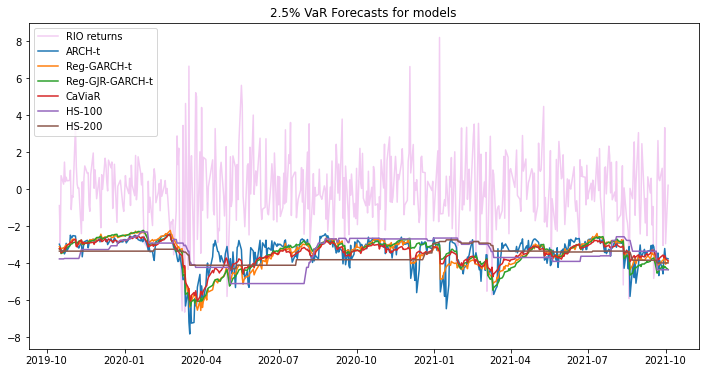

In [72]:
# 2.5% VaR forecasts 
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var25_arch_t, label='ARCH-t')
plt.plot(var25_reg_garch_t, label='Reg-GARCH-t')
plt.plot(var25_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(var25_caviar, label='CaViaR')
plt.plot(var25_hs100, label='HS-100')
plt.plot(var25_hs200, label='HS-200')

plt.title('2.5% VaR Forecasts for models')
plt.legend()
plt.show()

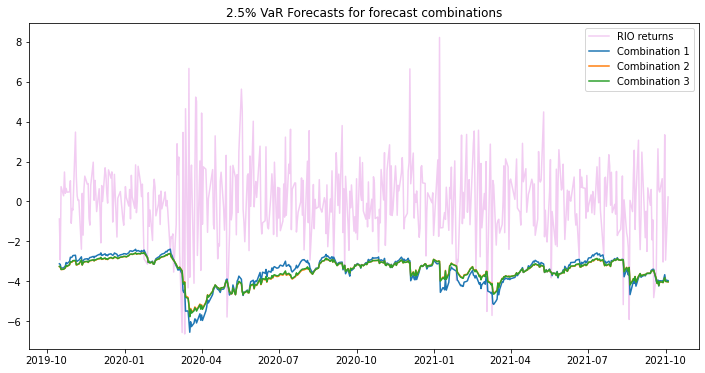

In [73]:
# 2.5% VaR forecasts with combinations
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var25_fcomb1, label='Combination 1')
plt.plot(var25_fcomb2, label='Combination 2')
plt.plot(var25_fcomb3, label='Combination 3')

plt.title('2.5% VaR Forecasts for forecast combinations')
plt.legend()
plt.show()

In [74]:
# Violations (hits)
hit25_arch_t = log_rio[frst_fc:] < var25_arch_t
hit1_arch_t = log_rio[frst_fc:] < var1_arch_t

hit25_garch_t = log_rio[frst_fc:] < var25_reg_garch_t
hit1_garch_t = log_rio[frst_fc:] < var1_reg_garch_t

hit25_gjr_t = log_rio[frst_fc:] < var25_reg_gjr_t
hit1_gjr_t = log_rio[frst_fc:] < var1_reg_gjr_t

hit25_caviar = log_rio[frst_fc:] < var25_caviar
hit1_caviar = log_rio[frst_fc:] < var1_caviar

hit25_hs100 = log_rio[frst_fc:] < var25_hs100
hit1_hs100 = log_rio[frst_fc:] < var1_hs100

hit25_hs200 = log_rio[frst_fc:] < var25_hs200
hit1_hs200 = log_rio[frst_fc:] < var1_hs200

hit25_f1 = log_rio[frst_fc:] < var25_fcomb1
hit1_f1 = log_rio[frst_fc:] < var1_fcomb1

hit25_f2 = log_rio[frst_fc:] < var25_fcomb2
hit1_f2 = log_rio[frst_fc:] < var1_fcomb2

hit25_f3 = log_rio[frst_fc:] < var25_fcomb3
hit1_f3 = log_rio[frst_fc:] < var1_fcomb3

#### VaR 2.5% Forecasts accuracy

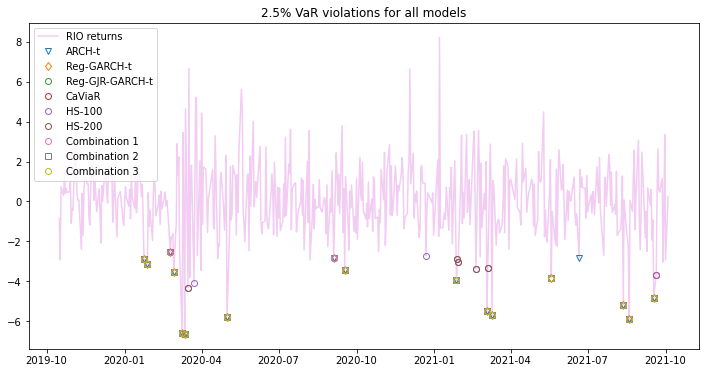

In [75]:
# 2.5% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(log_rio[frst_fc:][hit25_arch_t], 'v', mfc='none', label='ARCH-t')
plt.plot(log_rio[frst_fc:][hit25_garch_t], 'd', mfc='none', label='Reg-GARCH-t')
plt.plot(log_rio[frst_fc:][hit25_gjr_t], 'o', mfc='none', label='Reg-GJR-GARCH-t')
plt.plot(log_rio[frst_fc:][hit25_caviar], 'o', mfc='none', label='CaViaR')
plt.plot(log_rio[frst_fc:][hit25_hs100], 'o', mfc='none', label='HS-100')
plt.plot(log_rio[frst_fc:][hit25_hs200], 'o', mfc='none', label='HS-200')
plt.plot(log_rio[frst_fc:][hit25_f1], 'o', mfc='none', label='Combination 1')
plt.plot(log_rio[frst_fc:][hit25_f2], 's', mfc='none', label='Combination 2')
plt.plot(log_rio[frst_fc:][hit25_f3], 'o', mfc='none', label='Combination 3')

plt.title('2.5% VaR violations for all models')
plt.legend()
plt.show()

In [76]:
# 2.5% VaR forecast accuracy checks
tbl_var25 = pd.DataFrame({
    'ARCH-t': check_var_fc(var25_arch_t, log_rio[frst_fc:], 0.025),
    'Reg-GARCH-t': check_var_fc(var25_reg_garch_t, log_rio[frst_fc:], 0.025),
    'Reg-GJR-GARCH-t': check_var_fc(var25_reg_gjr_t, log_rio[frst_fc:], 0.025),
    'CaViaR': check_var_fc(var25_caviar, log_rio[frst_fc:], 0.025),
    'HS100': check_var_fc(var25_hs100, log_rio[frst_fc:], 0.025),
    'HS200': check_var_fc(var25_hs200, log_rio[frst_fc:], 0.025),
    'Combination 1': check_var_fc(var25_fcomb1, log_rio[frst_fc:], 0.025),
    'Combination 2': check_var_fc(var25_fcomb2, log_rio[frst_fc:], 0.025),
    'Combination 3': check_var_fc(var25_fcomb3, log_rio[frst_fc:], 0.025)},
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var25.round(4)

,ARCH-t,Reg-GARCH-t,Reg-GJR-GARCH-t,CaViaR,HS100,HS200,Combination 1,Combination 2,Combination 3
Viol. (25),16.0000,15.0000,16.0000,16.0000,23.0000,16.0000,16.0000,14.0000,14.0000
$\hat{p}$,0.0320,0.0300,0.0320,0.0320,0.0460,0.0320,0.0320,0.0280,0.0280
$\hat{p}/p$,1.2800,1.2000,1.2800,1.2800,1.8400,1.2800,1.2800,1.1200,1.1200
UC,0.3161,0.4739,0.3161,0.3161,0.0026,0.3161,0.3161,0.6674,0.6674
Ind,0.5310,0.4635,0.5310,0.0961,0.0025,0.0109,0.5310,0.3993,0.3993
DQ,0.0932,0.0884,0.1442,0.0211,0.0000,0.0000,0.1278,0.5224,0.5410
Loss,61.8129,62.9995,62.0395,62.3852,72.0568,67.8182,62.1938,63.6439,63.5003


#### 1% VaR Forecasts 

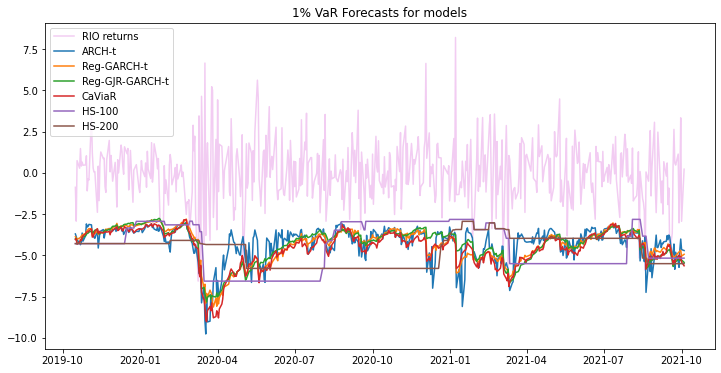

In [77]:
# 1% VaR forecasts 
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var1_arch_t, label='ARCH-t')
plt.plot(var1_reg_garch_t, label='Reg-GARCH-t')
plt.plot(var1_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(var1_caviar, label='CaViaR')
plt.plot(var1_hs100, label='HS-100')
plt.plot(var1_hs200, label='HS-200')

plt.title('1% VaR Forecasts for models')
plt.legend()
plt.show()

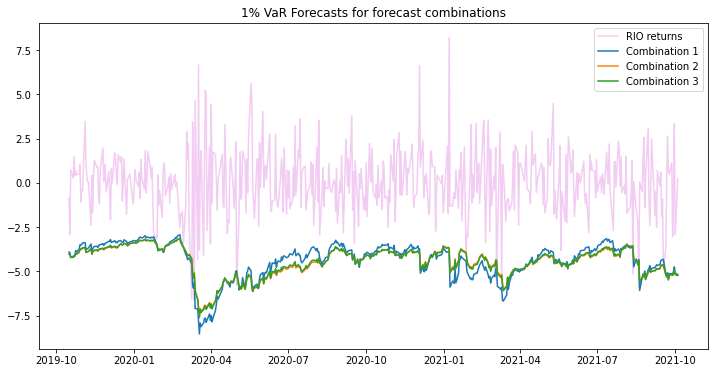

In [78]:
# 1% VaR forecasts with combinations
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(var1_fcomb1, label='Combination 1')
plt.plot(var1_fcomb2, label='Combination 2')
plt.plot(var1_fcomb3, label='Combination 3')

plt.title('1% VaR Forecasts for forecast combinations')
plt.legend()
plt.show()

#### VaR 1% Forecasts accuracy

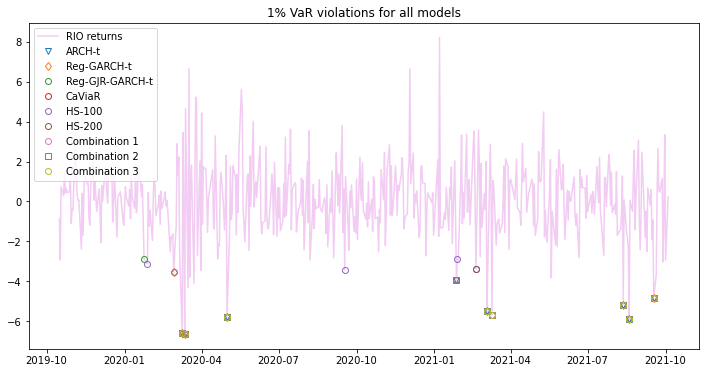

In [79]:
# 1% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(log_rio[frst_fc:][hit1_arch_t], 'v', mfc='none', label='ARCH-t')
plt.plot(log_rio[frst_fc:][hit1_garch_t], 'd', mfc='none', label='Reg-GARCH-t')
plt.plot(log_rio[frst_fc:][hit1_gjr_t], 'o', mfc='none', label='Reg-GJR-GARCH-t')
plt.plot(log_rio[frst_fc:][hit1_caviar], 'o', mfc='none', label='CaViaR')
plt.plot(log_rio[frst_fc:][hit1_hs100], 'o', mfc='none', label='HS-100')
plt.plot(log_rio[frst_fc:][hit1_hs200], 'o', mfc='none', label='HS-200')
plt.plot(log_rio[frst_fc:][hit1_f1], 'o', mfc='none', label='Combination 1')
plt.plot(log_rio[frst_fc:][hit1_f2], 's', mfc='none', label='Combination 2')
plt.plot(log_rio[frst_fc:][hit1_f3], 'o', mfc='none', label='Combination 3')

plt.title('1% VaR violations for all models')
plt.legend()
plt.show()

In [80]:
# 1% VaR forecast accuracy checks
tbl_var1 = pd.DataFrame({
    'ARCH-t': check_var_fc(var1_arch_t, log_rio[frst_fc:], 0.01),
    'Reg-GARCH-t': check_var_fc(var1_reg_garch_t, log_rio[frst_fc:], 0.01),
    'Reg-GJR-GARCH-t': check_var_fc(var1_reg_gjr_t, log_rio[frst_fc:], 0.01),
    'CaViaR': check_var_fc(var1_caviar, log_rio[frst_fc:], 0.01),
    'HS100': check_var_fc(var1_hs100, log_rio[frst_fc:], 0.01),
    'HS200': check_var_fc(var1_hs200, log_rio[frst_fc:], 0.01),
    'Combination 1': check_var_fc(var1_fcomb1, log_rio[frst_fc:], 0.01),
    'Combination 2': check_var_fc(var1_fcomb2, log_rio[frst_fc:], 0.01),
    'Combination 3': check_var_fc(var1_fcomb3, log_rio[frst_fc:], 0.01)},
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var1.round(4)

,ARCH-t,Reg-GARCH-t,Reg-GJR-GARCH-t,CaViaR,HS100,HS200,Combination 1,Combination 2,Combination 3
Viol. (25),8.0000,8.0000,8.0000,7.0000,12.0000,9.0000,7.0000,9.0000,8.0000
$\hat{p}$,0.0160,0.0160,0.0160,0.0140,0.0240,0.0180,0.0140,0.0180,0.0160
$\hat{p}/p$,1.6000,1.6000,1.6000,1.4000,2.4000,1.8000,1.4000,1.8000,1.6000
UC,0.1775,0.1775,0.1775,0.3687,0.0017,0.0722,0.3687,0.0722,0.1775
Ind,0.6096,0.6096,0.6096,0.6553,0.2831,0.5653,0.6553,0.5653,0.6096
DQ,0.0595,0.0594,0.0587,0.0414,0.0000,0.0000,0.0403,0.0019,0.0010
Loss,30.7076,30.7596,29.2771,29.9595,40.2140,37.5578,30.1113,31.9407,31.6626


## Part I Question (e)

#### 2.5% ES Forecasts

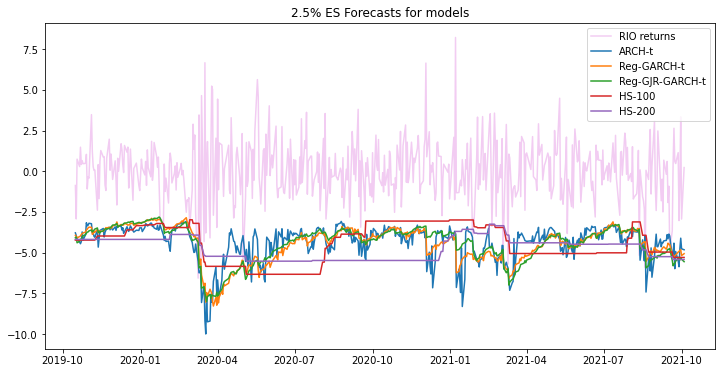

In [81]:
#2.5% ES Forecasts
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(es25_arch_t, label='ARCH-t')
plt.plot(es25_reg_garch_t, label='Reg-GARCH-t')
plt.plot(es25_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(es25_hs100, label='HS-100')
plt.plot(es25_hs200, label='HS-200')

plt.title('2.5% ES Forecasts for models')
plt.legend()
plt.show()

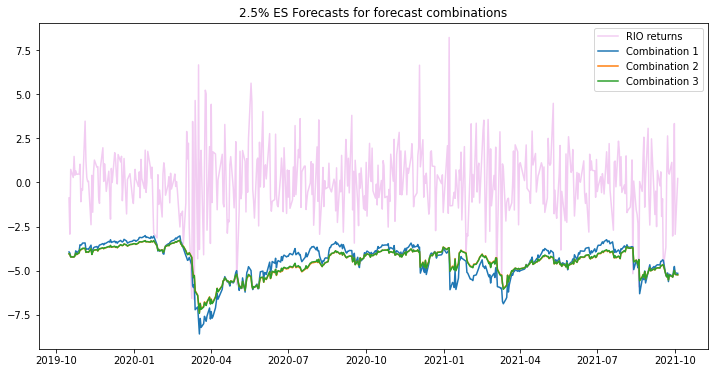

In [82]:
# 2.5% ES Forecasts with combinations
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(es25_fcomb1, label='Combination 1')
plt.plot(es25_fcomb2, label='Combination 2')
plt.plot(es25_fcomb3, label='Combination 3')

plt.title('2.5% ES Forecasts for forecast combinations')
plt.legend()
plt.show()

#### 2.5% ES Forecast accuracy

In [ ]:
'''# 2.5% ES forecast accuracy checks
tbl_es25 = pd.DataFrame({
    'ARCH-t': check_es_fc_ex_10(es25_arch_t, var25_arch_t, s_arch_t, log_rio[frst_fc:], 0.025),
    'Reg-GARCH-t': check_es_fc_ex_10(es25_reg_garch_t, var25_reg_garch_t, s_reg_garch_t, log_rio[frst_fc:], 0.025),
    'Reg-GJR-GARCH-t': check_es_fc_ex_10(es25_reg_gjr_t, var25_reg_gjr_t, s_reg_gjr_t, log_rio[frst_fc:], 0.025),
    'HS100': check_es_fc_ex_10(es25_hs100, var25_hs100, s_hs100, log_rio[frst_fc:], 0.025),
    'HS200': check_es_fc_ex_10(es25_hs200, var25_hs200, s_hs200, log_rio[frst_fc:], 0.025),
    'Combination 1': check_es_fc_ex_10(es25_fcomb1, var25_fcomb1, log_rio[frst_fc:], 0.025),
    'Combination 2': check_es_fc_ex_10(es25_fcomb2, var25_fcomb2, log_rio[frst_fc:], 0.025),
    'Combination 3': check_es_fc_ex_10(es25_fcomb3, var25_fcomb3, log_rio[frst_fc:], 0.025)},
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_es25.round(4)'''
# Problem: How to calculate s_ for combinations

In [83]:
# 2.5% ES forecast accuracy checks
tbl_es25 = pd.DataFrame({
    'ARCH-t': check_es_fc_ex_10(es25_arch_t, var25_arch_t, s_arch_t, log_rio[frst_fc:], 0.025),
    'Reg-GARCH-t': check_es_fc_ex_10(es25_reg_garch_t, var25_reg_garch_t, s_reg_garch_t, log_rio[frst_fc:], 0.025),
    'Reg-GJR-GARCH-t': check_es_fc_ex_10(es25_reg_gjr_t, var25_reg_gjr_t, s_reg_gjr_t, log_rio[frst_fc:], 0.025),
    'HS100': check_es_fc_ex_10(es25_hs100, var25_hs100, s_hs100, log_rio[frst_fc:], 0.025),
    'HS200': check_es_fc_ex_10(es25_hs200, var25_hs200, s_hs200, log_rio[frst_fc:], 0.025)},
    index=['Viol. (10?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es25.round(4)

,ARCH-t,Reg-GARCH-t,Reg-GJR-GARCH-t,HS100,HS200
Viol. (10?),7.0000,8.0000,8.0000,9.0000,9.0000
Mean xi,-0.2463,-0.3548,-0.2241,-0.2686,-0.4907
t xi,-1.0413,-1.4408,-1.0703,-0.9593,-1.7089
Mean xi/s,-0.1203,-0.1933,-0.1083,-0.2055,-0.2964
t-stat,-0.7993,-1.2785,-0.8386,-1.1318,-1.6931
p-val,0.4366,0.2219,0.4149,0.2699,0.1111
Joint loss,2.6082,2.6394,2.6061,2.8800,2.7735
RMSE,0.9486,0.9872,0.8412,1.3403,1.2157
MAD,0.8073,0.7202,0.6187,1.0085,0.9474


#### 1% ES Forecasts

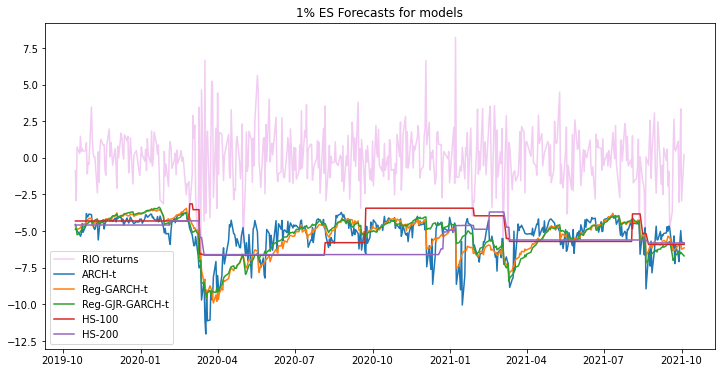

In [84]:
# 1% ES Forecasts
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(es1_arch_t, label='ARCH-t')
plt.plot(es1_reg_garch_t, label='Reg-GARCH-t')
plt.plot(es1_reg_gjr_t, label='Reg-GJR-GARCH-t')
plt.plot(es1_hs100, label='HS-100')
plt.plot(es1_hs200, label='HS-200')

plt.title('1% ES Forecasts for models')
plt.legend()
plt.show()

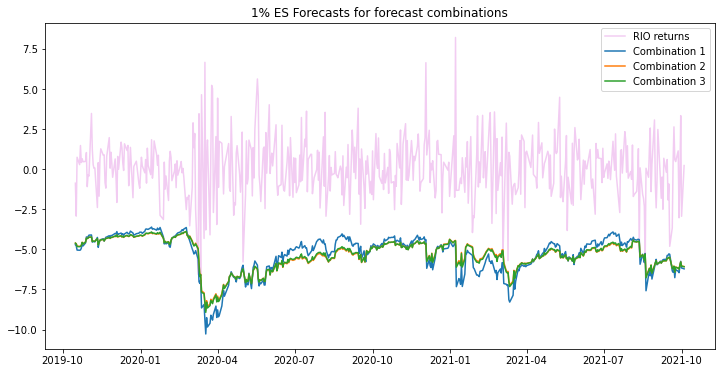

In [85]:
# 1% ES Forecasts with combinations
plt.figure(figsize=(12, 6))
plt.plot(log_rio[frst_fc:], '-m', alpha=0.2, label='RIO returns')
plt.plot(es1_fcomb1, label='Combination 1')
plt.plot(es1_fcomb2, label='Combination 2')
plt.plot(es1_fcomb3, label='Combination 3')

plt.title('1% ES Forecasts for forecast combinations')
plt.legend()
plt.show()

#### 1% ES Forecast accuracy

In [86]:
# 1% ES forecast accuracy checks
tbl_es1 = pd.DataFrame({
    'ARCH-t': check_es_fc_ex_10(es1_arch_t, var1_arch_t, s_arch_t, log_rio[frst_fc:], 0.01),
    'Reg-GARCH-t': check_es_fc_ex_10(es1_reg_garch_t, var1_reg_garch_t, s_reg_garch_t, log_rio[frst_fc:], 0.01),
    'Reg-GJR-GARCH-t': check_es_fc_ex_10(es1_reg_gjr_t, var1_reg_gjr_t, s_reg_gjr_t, log_rio[frst_fc:], 0.01),
    'HS100': check_es_fc_ex_10(es1_hs100, var1_hs100, s_hs100, log_rio[frst_fc:], 0.01),
    'HS200': check_es_fc_ex_10(es1_hs200, var1_hs200, s_hs200, log_rio[frst_fc:], 0.01)},
    index=['Viol. (10?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es1.round(4)

,ARCH-t,Reg-GARCH-t,Reg-GJR-GARCH-t,HS100,HS200
Viol. (10?),4.0000,4.0000,3.0000,8.0000,5.0000
Mean xi,-0.1205,-0.0926,0.0674,-0.2687,-0.4813
t xi,-0.4609,-0.2900,0.2363,-0.6733,-1.2791
Mean xi/s,-0.0991,-0.0787,0.0218,-0.2010,-0.3100
t-stat,-0.6257,-0.4161,0.1279,-0.7401,-1.3481
p-val,0.5513,0.6898,0.9018,0.4747,0.2146
Joint loss,2.8218,2.8256,2.7558,3.3016,3.1527
RMSE,0.7024,0.8502,0.7575,1.3508,1.1679
MAD,0.5520,0.7526,0.6580,1.0388,0.9750


## Part II Question (a)

Best parametric model: Reg2-GJR-GARCH(1,1)-t model

Best single adhoc model: HS-200 model

## Part II Question (b)

In [ ]:
r_c1=log_rio
r_c2=log_tls
r_c3=log_wes

In [143]:
# Reg_GJR-GARCH-t and HS200 for Asset 2

var25_reg_gjr_t_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
var1_reg_gjr_t_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
es25_reg_gjr_t_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
es1_reg_gjr_t_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')


var25_hs200_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
var1_hs200_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
es25_hs200_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
es1_hs200_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')

# Volatility
s_reg_gjr_t_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')
s_hs200_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_reg_gjr_t_2 = pd.Series(index=log_tls[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = log_tls[1:]
x = log_tls[:-1]
arch_t_2 = arch_model(y, mean='Constant', vol='ARCH', dist='StudentsT', p=7)


n_fore = len(log_tls[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    arch_t_2 = arch_model(y_is, mean='Constant', vol='ARCH', dist='StudentsT', p=7)
    reg_gjr_t_2 = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 1 == 0:
            arch_t_fit_2 = arch_t_2.fit( disp = "off" )
            reg_gjr_t_fit_2 = reg_gjr_t_2.fit( disp = "off" )
       
    # ARX-GJR-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_gjr_t_fit_2.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit_2.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit_2.params['nu'])
    var25_reg_gjr_t_2[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t_2[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit_2.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit_2.params['nu'])
    es25_reg_gjr_t_2[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t_2[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_gjr_t_2[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_gjr_t_2[i] = reg_gjr_t_fit_2.params['nu']
    if var25_reg_gjr_t_2[i] > 0:
        var25_reg_gjr_t_2[i] = var25_reg_gjr_t_2[i-1]
        es25_reg_gjr_t_2[i] = es25_reg_gjr_t_2[i-1]
        var1_reg_gjr_t_2[i] = var1_reg_gjr_t_2[i-1]
        es1_reg_gjr_t_2[i] = es1_reg_gjr_t_2[i-1]
        s_reg_gjr_t_2[i] = s_reg_gjr_t_2[i-1]
        
# HS-200
    var25_hs200_2[i] = log_tls[(i + n_wind - 200):(i + n_wind)].quantile(0.025)
    var1_hs200_2[i] = log_tls[(i + n_wind - 200):(i + n_wind)].quantile(0.01)
    es25_hs200_2[i] = es(log_tls[(i + n_wind - 200):(i + n_wind)], 0.025)
    es1_hs200_2[i] = es(log_tls[(i + n_wind - 200):(i + n_wind)], 0.01)
    s_hs200_2[i] = log_tls[(i + n_wind - 200):(i + n_wind)].std()

  0%|          | 0/500 [00:00<?, ?it/s]

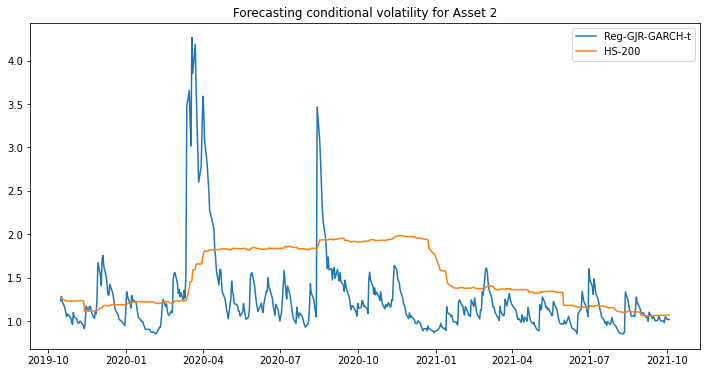

In [146]:
# Forecast
plt.figure(figsize=(12, 6))
plt.plot(s_reg_gjr_t_2, label='Reg-GJR-GARCH-t')
plt.plot(s_hs200_2, label='HS-200')

plt.title('Forecasting conditional volatility for Asset 2')
plt.legend()
plt.show()

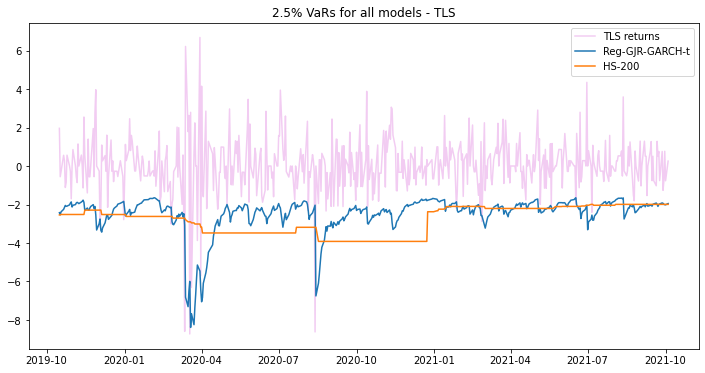

In [147]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_tls[frst_fc:], '-m', alpha=0.2, label='TLS returns')
plt.plot(var25_reg_gjr_t_2, label='Reg-GJR-GARCH-t')
plt.plot(var25_hs200_2, label='HS-200')

plt.title('2.5% VaRs for 2 models - TLS')
plt.legend()
plt.show()

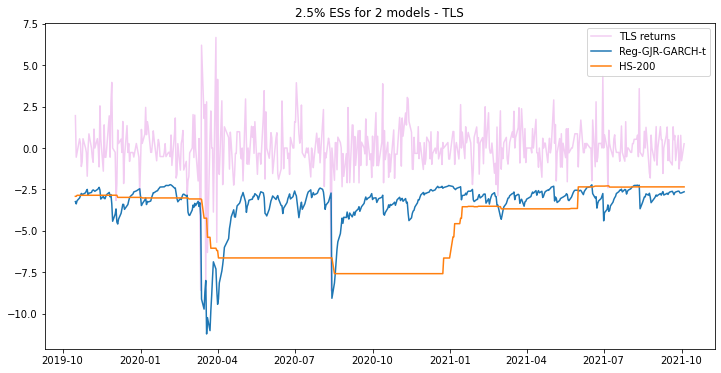

In [152]:
# ES 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_tls[frst_fc:], '-m', alpha=0.2, label='TLS returns')
plt.plot(es25_reg_gjr_t_2, label='Reg-GJR-GARCH-t')
plt.plot(es25_hs200_2, label='HS-200')

plt.title('2.5% ESs for 2 models - TLS')
plt.legend()
plt.show()

In [155]:
# Reg_GJR-GARCH-t and HS200 for Asset 3

var25_reg_gjr_t_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
var1_reg_gjr_t_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
es25_reg_gjr_t_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
es1_reg_gjr_t_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')


var25_hs200_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
var1_hs200_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
es25_hs200_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
es1_hs200_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')

# Volatility
s_reg_gjr_t_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')
s_hs200_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_reg_gjr_t_3 = pd.Series(index=log_wes[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = log_wes[1:]
x = log_wes[:-1]
arch_t_3 = arch_model(y, mean='Constant', vol='ARCH', dist='StudentsT', p=7)


n_fore = len(log_wes[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    arch_t_3 = arch_model(y_is, mean='Constant', vol='ARCH', dist='StudentsT', p=7)
    reg_gjr_t_3 = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 1 == 0:
            arch_t_fit_3 = arch_t_3.fit( disp = "off" )
            reg_gjr_t_fit_3 = reg_gjr_t_3.fit( disp = "off" )
       
    # ARX-GJR-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_gjr_t_fit_3.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit_3.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit_3.params['nu'])
    var25_reg_gjr_t_3[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t_3[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit_3.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit_3.params['nu'])
    es25_reg_gjr_t_3[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t_3[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_gjr_t_3[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_gjr_t_3[i] = reg_gjr_t_fit_3.params['nu']
    if var25_reg_gjr_t_3[i] > 0:
        var25_reg_gjr_t_3[i] = var25_reg_gjr_t_3[i-1]
        es25_reg_gjr_t_3[i] = es25_reg_gjr_t_3[i-1]
        var1_reg_gjr_t_3[i] = var1_reg_gjr_t_3[i-1]
        es1_reg_gjr_t_3[i] = es1_reg_gjr_t_3[i-1]
        s_reg_gjr_t_3[i] = s_reg_gjr_t_3[i-1]
        
# HS-200
    var25_hs200_3[i] = log_wes[(i + n_wind - 200):(i + n_wind)].quantile(0.025)
    var1_hs200_3[i] = log_wes[(i + n_wind - 200):(i + n_wind)].quantile(0.01)
    es25_hs200_3[i] = es(log_wes[(i + n_wind - 200):(i + n_wind)], 0.025)
    es1_hs200_3[i] = es(log_wes[(i + n_wind - 200):(i + n_wind)], 0.01)
    s_hs200_3[i] = log_wes[(i + n_wind - 200):(i + n_wind)].std()

  0%|          | 0/500 [00:00<?, ?it/s]

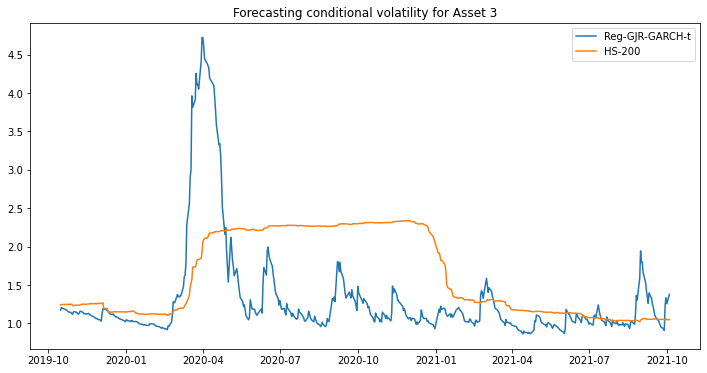

In [156]:
# Forecast
plt.figure(figsize=(12, 6))
plt.plot(s_reg_gjr_t_3, label='Reg-GJR-GARCH-t')
plt.plot(s_hs200_3, label='HS-200')

plt.title('Forecasting conditional volatility for Asset 3')
plt.legend()
plt.show()

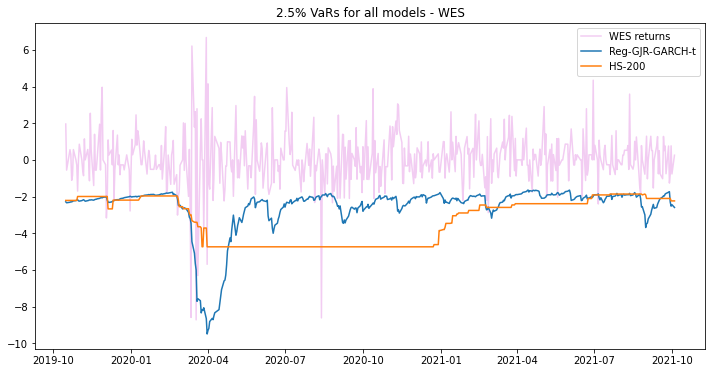

In [157]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_tls[frst_fc:], '-m', alpha=0.2, label='WES returns')
plt.plot(var25_reg_gjr_t_3, label='Reg-GJR-GARCH-t')
plt.plot(var25_hs200_3, label='HS-200')

plt.title('2.5% VaRs for all models - WES')
plt.legend()
plt.show()

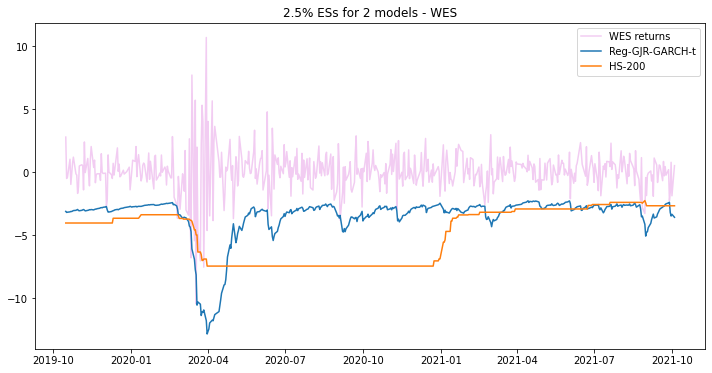

In [158]:
# ES 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_wes[frst_fc:], '-m', alpha=0.2, label='WES returns')
plt.plot(es25_reg_gjr_t_3, label='Reg-GJR-GARCH-t')
plt.plot(es25_hs200_3, label='HS-200')

plt.title('2.5% ESs for 2 models - WES')
plt.legend()
plt.show()

## Part II Question (c)

In [111]:
log_w = (log_rio + log_tls + log_wes)/3

In [112]:
log_w 

Date
2010-01-05    0.967823
2010-01-06   -0.125263
2010-01-07   -0.957863
2010-01-08    1.416403
2010-01-11    0.213109
                ...   
2021-09-28   -2.182573
2021-09-29   -0.986474
2021-09-30    1.632626
2021-10-01   -1.856205
2021-10-04    0.336848
Length: 2972, dtype: float64

In [159]:
# Reg_GJR-GARCH-t and HS200 for weighted portfolio 1

var25_reg_gjr_t_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
var1_reg_gjr_t_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
es25_reg_gjr_t_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
es1_reg_gjr_t_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')


var25_hs200_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
var1_hs200_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
es25_hs200_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
es1_hs200_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')

# Volatility
s_reg_gjr_t_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')
s_hs200_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_reg_gjr_t_4 = pd.Series(index=log_w[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = log_w[1:]
x = log_w[:-1]
arch_t_4 = arch_model(y, mean='Constant', vol='ARCH', dist='StudentsT', p=7)


n_fore = len(log_w[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    arch_t_4 = arch_model(y_is, mean='Constant', vol='ARCH', dist='StudentsT', p=7)
    reg_gjr_t_4 = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 1 == 0:
            arch_t_fit_4 = arch_t_4.fit( disp = "off" )
            reg_gjr_t_fit_4 = reg_gjr_t_4.fit( disp = "off" )
       
    # ARX-GJR-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_gjr_t_fit_4.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit_4.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit_4.params['nu'])
    var25_reg_gjr_t_4[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t_4[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit_4.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit_4.params['nu'])
    es25_reg_gjr_t_4[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t_4[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_gjr_t_4[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_gjr_t_4[i] = reg_gjr_t_fit_4.params['nu']
    if var25_reg_gjr_t_4[i] > 0:
        var25_reg_gjr_t_4[i] = var25_reg_gjr_t_4[i-1]
        es25_reg_gjr_t_4[i] = es25_reg_gjr_t_4[i-1]
        var1_reg_gjr_t_4[i] = var1_reg_gjr_t_4[i-1]
        es1_reg_gjr_t_4[i] = es1_reg_gjr_t_4[i-1]
        s_reg_gjr_t_4[i] = s_reg_gjr_t_4[i-1]
        
# HS-200
    var25_hs200_4[i] = log_w[(i + n_wind - 200):(i + n_wind)].quantile(0.025)
    var1_hs200_4[i] = log_w[(i + n_wind - 200):(i + n_wind)].quantile(0.01)
    es25_hs200_4[i] = es(log_w[(i + n_wind - 200):(i + n_wind)], 0.025)
    es1_hs200_4[i] = es(log_w[(i + n_wind - 200):(i + n_wind)], 0.01)
    s_hs200_4[i] = log_w[(i + n_wind - 200):(i + n_wind)].std()

  0%|          | 0/500 [00:00<?, ?it/s]

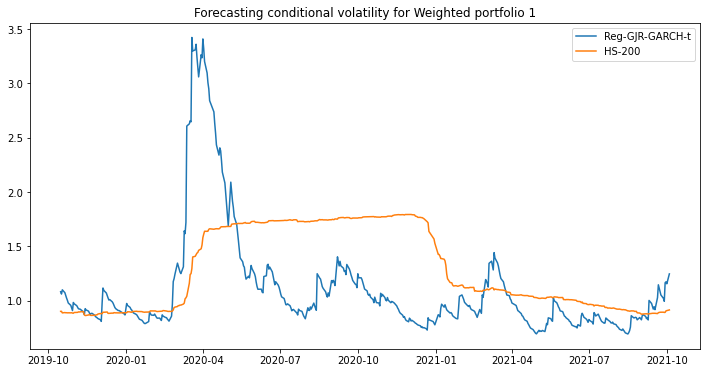

In [160]:
# Forecast
plt.figure(figsize=(12, 6))
plt.plot(s_reg_gjr_t_4, label='Reg-GJR-GARCH-t')
plt.plot(s_hs200_4, label='HS-200')

plt.title('Forecasting conditional volatility for Weighted portfolio 1')
plt.legend()
plt.show()

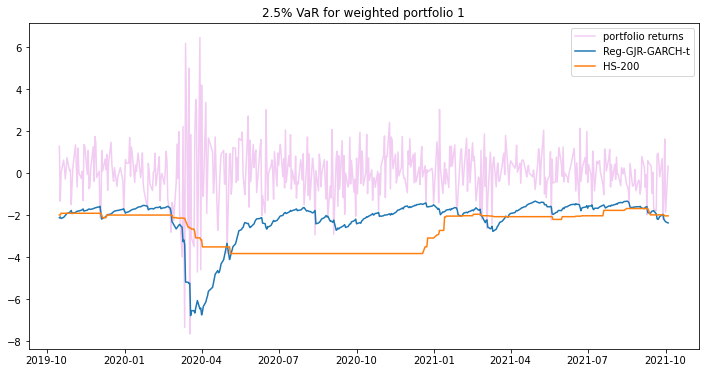

In [161]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_w[frst_fc:], '-m', alpha=0.2, label='portfolio returns')
plt.plot(var25_reg_gjr_t_4, label='Reg-GJR-GARCH-t')
plt.plot(var25_hs200_4, label='HS-200')

plt.title('2.5% VaR for weighted portfolio 1')
plt.legend()
plt.show()

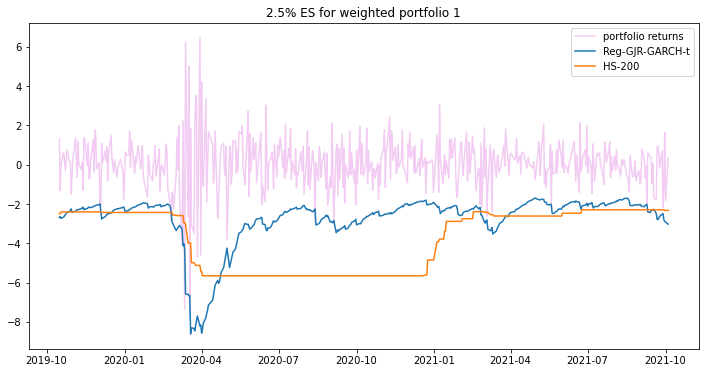

In [162]:
# ES 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_w[frst_fc:], '-m', alpha=0.2, label='portfolio returns')
plt.plot(es25_reg_gjr_t_4, label='Reg-GJR-GARCH-t')
plt.plot(es25_hs200_4, label='HS-200')

plt.title('2.5% ES for weighted portfolio 1')
plt.legend()
plt.show()

## Part II Question (d)

In [165]:
reg_gjr_t_1_in= arch_model(log_rio[1:n_wind], mean='ARX', lags=0, x = log_rio[:n_wind-1], vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
reg_gjr_t_fit_1_in = reg_gjr_t_1_in.fit( disp = "off" )
s_reg_gjr_t_1_in = reg_gjr_t_fit_1_in.conditional_volatility

reg_gjr_t_2_in= arch_model(log_tls[1:n_wind], mean='ARX', lags=0, x = log_tls[:n_wind-1], vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
reg_gjr_t_fit_2_in = reg_gjr_t_2_in.fit( disp = "off" )
s_reg_gjr_t_2_in = reg_gjr_t_fit_2_in.conditional_volatility

reg_gjr_t_3_in= arch_model(log_wes[1:n_wind], mean='ARX', lags=0, x = log_wes[:n_wind-1], vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
reg_gjr_t_fit_3_in = reg_gjr_t_3_in.fit( disp = "off" )
s_reg_gjr_t_3_in = reg_gjr_t_fit_3_in.conditional_volatility   

In [172]:
cs_gjr_1=np.mean(s_reg_gjr_t_1_in [-100:], axis=0)
cs_gjr_2=np.mean(s_reg_gjr_t_2_in [-100:], axis=0)
cs_gjr_3=np.mean(s_reg_gjr_t_3_in [-100:], axis=0)

r_name=['s_reg_gjr_t_1','s_reg_gjr_t_2','s_reg_gjr_t_3']
tbl_1=pd.DataFrame([cs_gjr_1,cs_gjr_2,cs_gjr_3],columns=['Average Volatility over last 100 days'],index=r_name)
tbl_1

,Average Volatility over last 100 days
s_reg_gjr_t_1,1.715996
s_reg_gjr_t_2,1.181222
s_reg_gjr_t_3,1.237756


In [173]:
tbl_2=1/tbl_1
tbl_3=tbl_2/np.sum(tbl_2)
tbl_3

,Average Volatility over last 100 days
s_reg_gjr_t_1,0.260477
s_reg_gjr_t_2,0.378403
s_reg_gjr_t_3,0.361120


In [176]:
log_p = log_rio*tbl_3.iloc[0].values + log_tls*tbl_3.iloc[1].values + log_wes*tbl_3.iloc[2].values
log_p

Date
2010-01-05    0.853199
2010-01-06   -0.455858
2010-01-07   -1.122317
2010-01-08    1.564155
2010-01-11    0.090142
                ...   
2021-09-28   -2.081268
2021-09-29   -1.021883
2021-09-30    1.445897
2021-10-01   -1.728541
2021-10-04    0.346619
Length: 2972, dtype: float64

In [177]:
# Reg_GJR-GARCH-t and HS200 for weighted portfolio 2

var25_reg_gjr_t_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
var1_reg_gjr_t_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
es25_reg_gjr_t_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
es1_reg_gjr_t_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')


var25_hs200_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
var1_hs200_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
es25_hs200_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
es1_hs200_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')

# Volatility
s_reg_gjr_t_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')
s_hs200_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_reg_gjr_t_5 = pd.Series(index=log_p[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = log_p[1:]
x = log_p[:-1]
arch_t_5 = arch_model(y, mean='Constant', vol='ARCH', dist='StudentsT', p=7)


n_fore = len(log_p[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    arch_t_5 = arch_model(y_is, mean='Constant', vol='ARCH', dist='StudentsT', p=7)
    reg_gjr_t_5 = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 1 == 0:
            arch_t_fit_5 = arch_t_5.fit( disp = "off" )
            reg_gjr_t_fit_5 = reg_gjr_t_5.fit( disp = "off" )
       
    # ARX-GJR-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_gjr_t_fit_5.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit_5.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit_5.params['nu'])
    var25_reg_gjr_t_5[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t_5[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit_5.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit_5.params['nu'])
    es25_reg_gjr_t_5[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t_5[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_gjr_t_5[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_gjr_t_5[i] = reg_gjr_t_fit_5.params['nu']
    if var25_reg_gjr_t_5[i] > 0:
        var25_reg_gjr_t_5[i] = var25_reg_gjr_t_5[i-1]
        es25_reg_gjr_t_5[i] = es25_reg_gjr_t_5[i-1]
        var1_reg_gjr_t_5[i] = var1_reg_gjr_t_5[i-1]
        es1_reg_gjr_t_5[i] = es1_reg_gjr_t_5[i-1]
        s_reg_gjr_t_5[i] = s_reg_gjr_t_5[i-1]
        
# HS-200
    var25_hs200_5[i] = log_p[(i + n_wind - 200):(i + n_wind)].quantile(0.025)
    var1_hs200_5[i] = log_p[(i + n_wind - 200):(i + n_wind)].quantile(0.01)
    es25_hs200_5[i] = es(log_p[(i + n_wind - 200):(i + n_wind)], 0.025)
    es1_hs200_5[i] = es(log_p[(i + n_wind - 200):(i + n_wind)], 0.01)
    s_hs200_5[i] = log_p[(i + n_wind - 200):(i + n_wind)].std()

  0%|          | 0/500 [00:00<?, ?it/s]

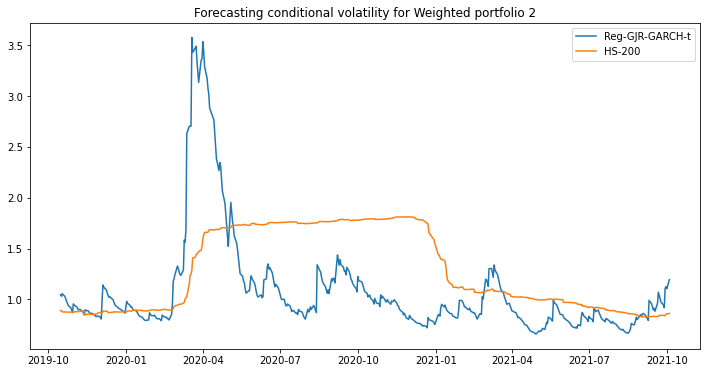

In [178]:
# Forecast
plt.figure(figsize=(12, 6))
plt.plot(s_reg_gjr_t_5, label='Reg-GJR-GARCH-t')
plt.plot(s_hs200_5, label='HS-200')

plt.title('Forecasting conditional volatility for Weighted portfolio 2')
plt.legend()
plt.show()

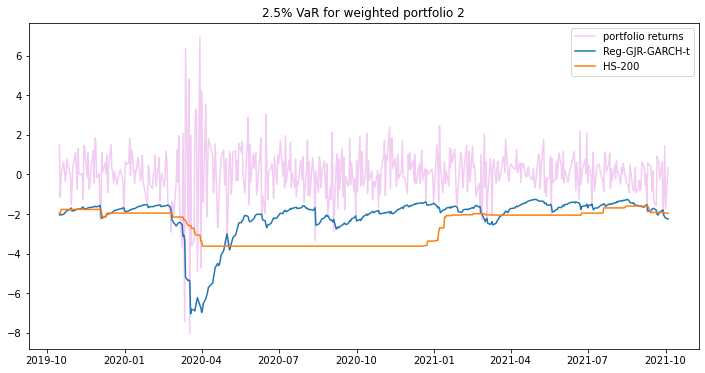

In [179]:
# VaR 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_p[frst_fc:], '-m', alpha=0.2, label='portfolio returns')
plt.plot(var25_reg_gjr_t_5, label='Reg-GJR-GARCH-t')
plt.plot(var25_hs200_5, label='HS-200')

plt.title('2.5% VaR for weighted portfolio 2')
plt.legend()
plt.show()

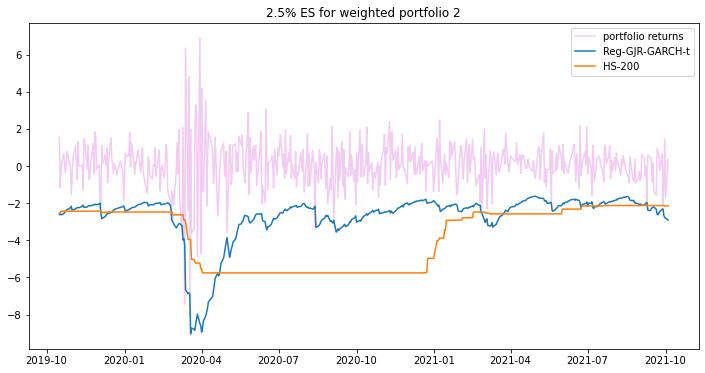

In [180]:
# ES 2.5%
plt.figure(figsize=(12, 6))
plt.plot(log_p[frst_fc:], '-m', alpha=0.2, label='portfolio returns')
plt.plot(es25_reg_gjr_t_5, label='Reg-GJR-GARCH-t')
plt.plot(es25_hs200_5, label='HS-200')

plt.title('2.5% ES for weighted portfolio 2')
plt.legend()
plt.show()

## Part II Question (e)

In [182]:
mn_1 = np.mean(log_rio[-n_fore:], axis=0)
sd_1 = np.std(log_rio[-n_fore:], axis=0, ddof=1)
ratio_1 = mn_1/sd_1

mn_2 = np.mean(log_tls[-n_fore:], axis=0)
sd_2 = np.std(log_tls[-n_fore:], axis=0, ddof=1)
ratio_2 = mn_2/sd_2

mn_3 = np.mean(log_wes[-n_fore:], axis=0)
sd_3 = np.std(log_wes[-n_fore:], axis=0, ddof=1)
ratio_3 = mn_3/sd_3

mn_4 = np.mean(log_w[-n_fore:], axis=0)
sd_4 = np.std(log_w[-n_fore:], axis=0, ddof=1)
ratio_4 = mn_4/sd_4

mn_5 = np.mean(log_p[-n_fore:], axis=0)
sd_5 = np.std(log_p[-n_fore:], axis=0, ddof=1)
ratio_5 = mn_5/sd_5

In [188]:
r_name=['Mean Return','Standard Deviation','Ratio']
tbl_4 = pd.DataFrame([[mn_1,mn_2,mn_3,mn_4,mn_5],
                      [sd_1,sd_2,sd_3,sd_4,sd_5],
                      [ratio_1,ratio_2,ratio_3,ratio_4,ratio_5]],
                     columns=['Asset1-rio','Asset2-tls','Asset3-wes','Equal weights','Fixed weights'],
                     index=r_name)
tbl_4

,Asset1-rio,Asset2-tls,Asset3-wes,Equal weights,Fixed weights
Mean Return,0.032586,0.026925,0.076504,0.045339,0.046304
Standard Deviation,1.880812,1.507212,1.677578,1.328280,1.323566
Ratio,0.017326,0.017864,0.045604,0.034133,0.034984
